Simple dataclass hierarchy storage in PQG.

This content is for testing purposes, it doesn't reflect the actual material sample record structure.

In [1]:
import dataclasses
import datetime
import json
import logging
import typing
import pqg

logging.basicConfig(level=logging.INFO)
   
@dataclasses.dataclass(kw_only=True)
class Agent(pqg.Base):
    affiliation: pqg.OptionalStr = None
    contact: pqg.OptionalStr = None
    
    
@dataclasses.dataclass(kw_only=True)
class GeoLocation(pqg.Base):
    longitude: float
    latitude: float
    zoffset: pqg.OptionalFloat = None
    zreference: pqg.OptionalStr = None
    
        
@dataclasses.dataclass(kw_only=True)
class SamplingSite(pqg.Base):
    location: GeoLocation = None


@dataclasses.dataclass(kw_only=True)
class SamplingEvent(pqg.Base):
    tstamp: pqg.OptionalDateTime = None
    responsibility: Agent = None
    sampling_site: SamplingSite = None
    

@dataclasses.dataclass(kw_only=True)
class MaterialSample(pqg.Base):
    registrant: Agent = None
    produced_by: SamplingEvent = None


graph = pqg.PQG()
graph.initialize(classes=[MaterialSample,])


INFO:pqg:No metadata available.


In [2]:
import faker
gen = faker.Faker()

agents = []
for i in range(10):
    agents.append(Agent(
        pid=f"agent_{i}",
        label=gen.name()
    ))

sites = []
for i in range(10):
   sites.append(SamplingSite(
       pid=f"site_{i}",
       location = GeoLocation(
           pid=f"geo_{i}",
           longitude=gen.longitude(),
           latitude=gen.latitude(),
           zoffset=gen.random_number(digits=3),
           zreference='MSL'
       )
   ))
for i in range(5):
    revent = SamplingEvent(
        pid=f"event_{i}",
        tstamp=gen.date_time(tzinfo=datetime.timezone.utc),
        responsibility=agents[gen.random_int(min=0, max=len(agents)-1)],
        sampling_site=sites[gen.random_int(min=0, max=len(sites)-1)]
    )
    ms = MaterialSample(
        pid=f"sample_{i}",
        label=f"Fake Sample {i}",
        description=gen.text(),
        registrant = agents[gen.random_int(min=0, max=len(agents)-1)],
        produced_by = revent
    )
    graph.addNode(ms)


sample_event = SamplingEvent(
    pid = "event_01",
    tstamp = datetime.datetime.now(tz=datetime.timezone.utc),
    responsibility = agents[gen.random_int(min=0, max=len(agents)-1)],
    sampling_site = SamplingSite(
        pid="site_01",
        location=GeoLocation(
            pid="geo_01",
            longitude=-76.5656,
            latitude=39.023,
            zoffset=32.0,
            zreference="MSL"
        )
    )
)
ms = MaterialSample(
    pid="ms01", 
    label="MS 01", 
    description="MS 01 description string",
    registrant = agents[gen.random_int(min=0, max=len(agents)-1)],
    produced_by = sample_event,
    altids=["MS01", "MS-01", "MS_01"]
)
graph.addNode(ms)

sample_event = SamplingEvent(
    pid = "event_02",
    tstamp = datetime.datetime.now(tz=datetime.timezone.utc),
    responsibility = agents[gen.random_int(min=0, max=len(agents)-1)],
    sampling_site = SamplingSite(
        pid="site_02",
        location=GeoLocation(
            pid="geo_02",
            longitude=-78.5656,
            latitude=38.023,
            zoffset=32.0,
            zreference="MSL"
        )
    )
)
ms = MaterialSample(
    pid="ms02", 
    label="MS 02", 
    description="MS 02 description string",
    registrant = agents[gen.random_int(min=0, max=len(agents)-1)],
    produced_by = sample_event
)
graph.addNode(ms)

'ms02'

In [3]:
data = graph.getNode("ms01")
print(json.dumps(data, indent=2, cls=pqg.JSONDateTimeEncoder))

{
  "pid": "ms01",
  "label": "MS 01",
  "description": "MS 01 description string",
  "registrant": {
    "pid": "agent_0",
    "label": "Scott Smith",
    "description": null,
    "affiliation": null,
    "contact": null
  },
  "produced_by": {
    "pid": "event_01",
    "label": null,
    "description": null,
    "tstamp": "2025-02-17T23:28:40.344072-05:00",
    "responsibility": {
      "pid": "agent_5",
      "label": "Tom Chase",
      "description": null,
      "affiliation": null,
      "contact": null
    },
    "sampling_site": {
      "pid": "site_01",
      "label": null,
      "description": null,
      "location": {
        "pid": "geo_01",
        "label": null,
        "description": null,
        "longitude": -76.5656,
        "latitude": 39.023,
        "zoffset": 32.0,
        "zreference": "MSL"
      }
    }
  }
}


INFO:plantweb.defaults:Defaults file /Users/vieglais/.plantwebrc doesn't exists
INFO:plantweb.defaults:Defaults file /Users/vieglais/Documents/Projects/isamples/source/pqg_dev/pqg/.plantwebrc doesn't exists


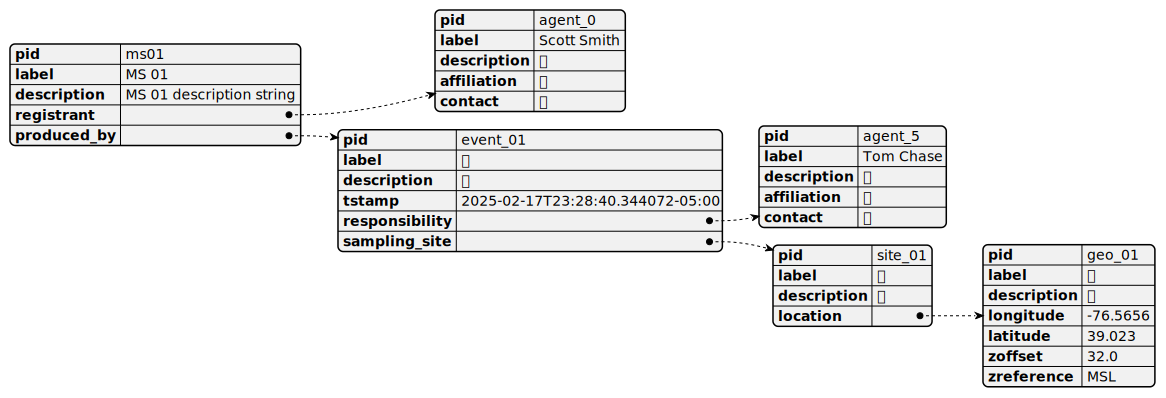

In [4]:
import json
import IPython.display
import plantweb.render

def displayPlantuml(content):
    _svg = plantweb.render.render(
                content,
                engine="plantuml",
                format="svg",
                cacheopts={"use_cache":False}
            )
    IPython.display.display(
        IPython.display.SVG(
            _svg[0]
        )
    )

displayPlantuml(f"@startjson\n{json.dumps(data, indent=2, cls=pqg.JSONDateTimeEncoder)}\n@endjson")


In [5]:
import IPython.display
import graphviz

nlights = graph.getNodeIds("ms01")
nlights

{'agent_0', 'agent_5', 'event_01', 'geo_01', 'ms01', 'site_01'}

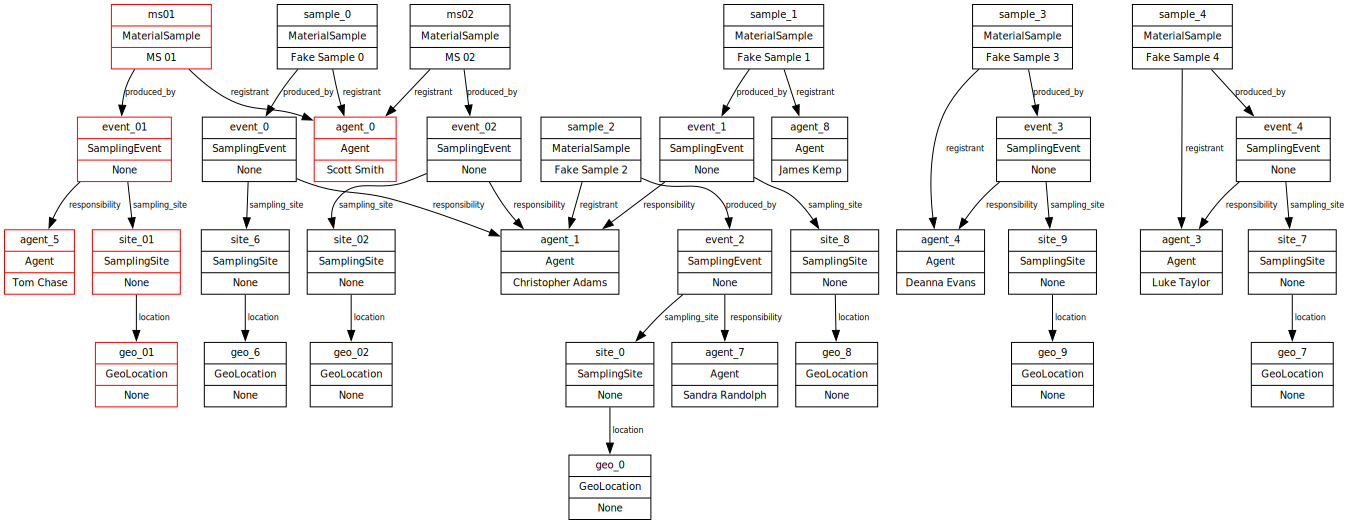

In [6]:
dot = "\n".join(graph.toGraphviz(nlights=nlights))
gv = graphviz.Source(dot)
IPython.display.display(gv)

In [7]:
def getEntityFor(ggraph, o:str):
    """Given subject, return the list of edges that directly or indirectly refer to it
    for any degrees of separation.
    """
    sql = f"""
    WITH RECURSIVE edges_for(pid, s, p, o, n, depth, stype) AS (
        SELECT e.pid, e.s, e.p, e.o, e.n, 1 as depth, node.otype as stype FROM node AS e JOIN node ON node.pid = e.s WHERE e.o = ?
    UNION ALL
        SELECT e.pid, e.s, e.p, e.o, e.n, eg.depth+1 AS depth, node.otype as stype 
        FROM node AS e, edges_for as eg JOIN node ON node.pid = e.s 
        WHERE e.o = eg.s
    ) SELECT * FROM edges_for;
    """
    with ggraph.getCursor() as csr:
        result = csr.execute(sql, [o])
        row = result.fetchone()
        while row is not None:
            yield row
            row = result.fetchone()

def nodeDict(n):
    print(n)
    res = {
        "pid": n.pid,
        "name": n.name,
        "description": n.description,
    }
    p = json.loads(n.properties)
    for k, v in p.items():
        res[k] = v
    return res


def getentity(ggraph, s):
    """Reconstruct a dataclass instance from its components.

    1. get the referenced entity
    2. Get the entity edges
    3. get the edge referenced entities
    4. for each of entities in 3, go to 1
    """
    _nodes = {
        s: nodeDict(ggraph.getNode(s)),
    }
    _edges = []
    for edge in getEntityEdges(ggraph, s):
        o = edge[3]
        _edges.append((edge[1], edge[2], edge[3]))
        if not o in _nodes.keys():
            _nodes[o] = nodeDict(ggraph.getNode(o))
    for edge in _edges:
        _nodes[edge[0]][edge[1]] = _nodes[edge[2]]
    return _nodes



for row in getEntityFor(graph, "geo_02"):
    print(row)

#print(json.dumps(getentity(graph, "ms01"), indent=2))


('anon_f20367981c86ace60e59c63c832ea548c03279cfac993a6f902c6e3e5a0eea42', 'site_02', 'location', 'geo_02', None, 1, 'SamplingSite')
('anon_d1c63415bbdb9362f3d5ba11558fc3775ef5e582db37988364a88bba7082ac74', 'event_02', 'sampling_site', 'site_02', None, 2, 'SamplingEvent')
('anon_0d719e17aa3b83b9308c756e882335bc6cb119a2664c056a014380bdf6c4a894', 'ms02', 'produced_by', 'event_02', None, 3, 'MaterialSample')


In [8]:
for row in graph.getRootsForPid(["geo_02",],):
    print(row)

('anon_f20367981c86ace60e59c63c832ea548c03279cfac993a6f902c6e3e5a0eea42', 'site_02', 'location', 'geo_02', None, 1, 'SamplingSite')
('anon_d1c63415bbdb9362f3d5ba11558fc3775ef5e582db37988364a88bba7082ac74', 'event_02', 'sampling_site', 'site_02', None, 2, 'SamplingEvent')
('anon_0d719e17aa3b83b9308c756e882335bc6cb119a2664c056a014380bdf6c4a894', 'ms02', 'produced_by', 'event_02', None, 3, 'MaterialSample')


In [9]:
for row in graph.getRootsForPid(["geo_02",], predicates=['location', 'sampling_site']):
    print(row)

('anon_f20367981c86ace60e59c63c832ea548c03279cfac993a6f902c6e3e5a0eea42', 'site_02', 'location', 'geo_02', None, 1, 'SamplingSite')
('anon_d1c63415bbdb9362f3d5ba11558fc3775ef5e582db37988364a88bba7082ac74', 'event_02', 'sampling_site', 'site_02', None, 2, 'SamplingEvent')


In [10]:
for row in graph.getRootsForPid(["geo_02","geo_01"], target_type='MaterialSample'):
    print(row)

('anon_8edc0383b4c4de9e559b2ce8609ceb081aba4e689974493a07068c8321aeeed6', 'ms01', 'produced_by', 'event_01', None, 3, 'MaterialSample')
('anon_0d719e17aa3b83b9308c756e882335bc6cb119a2664c056a014380bdf6c4a894', 'ms02', 'produced_by', 'event_02', None, 3, 'MaterialSample')


In [12]:
import pathlib

base_name = pathlib.Path("./dataclass_")
graph.asParquet(base_name)
